In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import io

In [4]:
from google.colab import files


uploaded = files.upload()

Saving train.csv to train.csv


In [5]:
# -------------------- Load Data --------------------
df_sales = pd.read_csv(io.BytesIO(uploaded['train.csv']))  # first CSV



/tmp/ipython-input-5-1812456263.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales = pd.read_csv(io.BytesIO(uploaded['train.csv']))  # first CSV


In [6]:
from google.colab import files


uploaded = files.upload()

Saving store.csv to store.csv


In [7]:
df_store = pd.read_csv(io.BytesIO(uploaded['store.csv']))  # second CSV

# Data Preparation

In [8]:
df = df_sales.merge(df_store, on='Store')

# Convert date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# Aggregate by date
df_daily = df.groupby("Date")[['Sales', 'Customers', 'Promo2']].mean().reset_index()

# -------------------- Remove Outliers --------------------
thresholds = df_daily[['Sales', 'Customers']].quantile(0.99)
df_daily = df_daily[(df_daily['Sales'] < thresholds['Sales']) & (df_daily['Customers'] < thresholds['Customers'])]

# -------------------- Standardize --------------------
scaler = StandardScaler()
df_scaled = df_daily.copy()
df_scaled[['Sales', 'Customers']] = scaler.fit_transform(df_scaled[['Sales', 'Customers']])

In [9]:
# -------------------- Check Stationarity --------------------
def adf_test(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test for {name}')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print('-'*30)
    return result[1] < 0.05

is_stationary = {col: adf_test(df_scaled[col], col) for col in ['Sales', 'Customers', 'Promo2']}


ADF Test for Sales
ADF Statistic: -6.660132536614632
p-value: 4.8707007708632735e-09
------------------------------
ADF Test for Customers
ADF Statistic: -6.662294848702382
p-value: 4.813157513026424e-09
------------------------------
ADF Test for Promo2
ADF Statistic: -1.7926029553093121
p-value: 0.38414025587478334
------------------------------


In [10]:
# -------------------- Differencing if Non-stationary --------------------
df_diff = df_scaled.copy()
if not all(is_stationary.values()):
    df_diff = df_diff.set_index("Date").diff().dropna()

In [11]:
# -------------------- Johansen Cointegration Test --------------------
def johansen_test(df):
    johansen = coint_johansen(df, det_order=0, k_ar_diff=1)
    trace_stat = johansen.lr1
    crit_vals = johansen.cvt[:, 1]
    print("Johansen Cointegration Test:")
    print("Trace Statistic | 5% Critical Value")
    for stat, crit in zip(trace_stat, crit_vals):
        print(f"{stat:.2f}           | {crit:.2f}")
    return any(trace_stat > crit_vals)

johansen_test(df_diff)

Johansen Cointegration Test:
Trace Statistic | 5% Critical Value
1711.65           | 29.80
781.73           | 15.49
375.46           | 3.84


True

# Model Building

In [12]:

model = VAR(df_diff)
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 29, Jun, 2025
Time:                     06:11:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -16.4234
Nobs:                     916.000    HQIC:                  -16.8138
Log likelihood:           4031.86    FPE:                3.91976e-08
AIC:                     -17.0548    Det(Omega_mle):     3.44804e-08
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000018         0.018933           -0.001           0.999
L1.Sales              0.801304         0.183802            4.360           0.000
L1.Customers         -1.930130         0.181459          -10

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Forecasting for 6 weeks

In [13]:

forecast = results.forecast(df_diff.values[-results.k_ar:], steps=42)
forecast_df = pd.DataFrame(forecast, columns=df_diff.columns)
forecast_df[['Sales', 'Customers']] = scaler.inverse_transform(forecast_df[['Sales', 'Customers']])


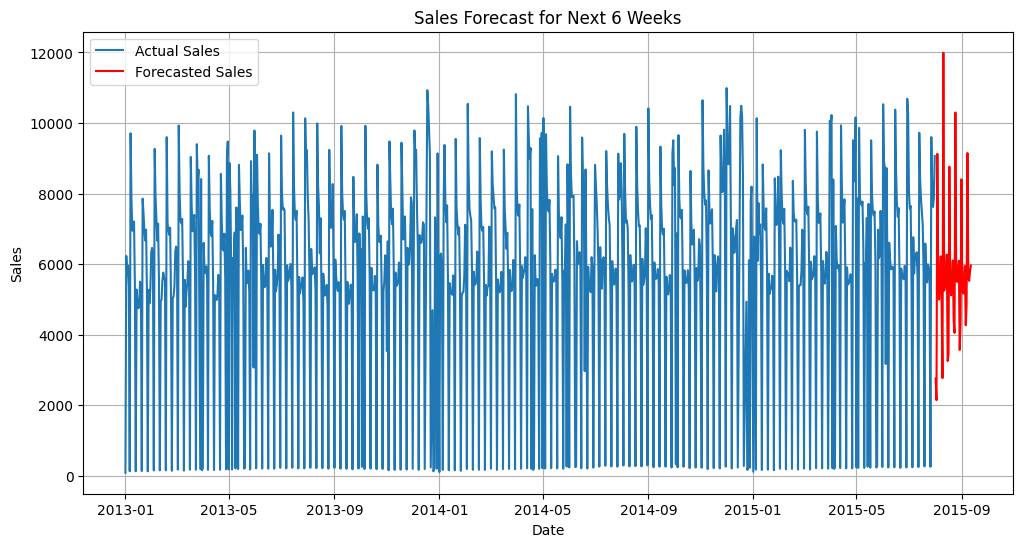

In [14]:
# -------------------- Plot Sales Forecast --------------------
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Date'], df_daily['Sales'], label='Actual Sales')
future_dates = pd.date_range(start=df_daily['Date'].iloc[-1] + pd.Timedelta(days=1), periods=42)
plt.plot(future_dates, forecast_df['Sales'], label='Forecasted Sales', color='red')
plt.title("Sales Forecast for Next 6 Weeks")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()